# Trabajo Práctico 2: Análisis de series temporales de EEG


<p style="text-align: justify;">
En el marco de la materia optativa *Ciencia de Datos* estudiamos series temporales adquiridas mediante la técnica de neuroimágenes de electroencefalografía (EEG). En la [página web de la materia](http://www.dc.uba.ar/materias/cienciadatos) se encuentran disponibles los [datos](http://calamaro.exp.dc.uba.ar/~fraimondo/cienciadatos/data/) utilizados, así como también las [referencias teóricas](http://www.dc.uba.ar/materias/cienciadatos/teoricas) y la [guía](https://gist.github.com/fraimondo/57990372c3c8a87c2c1bd290bffaa46f) para el desarrollo de los análisis correspondientes. <br>
En el presente trabajo nos interiorizamos en el estudio de señales de EEG a partir del análisis de frecuencias y de información utilizando herramientas de Python. Cargamos los datos ya preprocesados y discutimos brevemente acerca de los parámetros de adquisición y de los efectos del preprocesado en las señales a partir de un sujeto de ejemplo. Una vez comprendida la naturaleza de los datos y su adquisición, procedimos a realizar el análisis de frecuencias de las series a partir de aplicar la transformada de Fourier (short-time FFT) mediante el método de Welch. Realizamos el análisis espectral para la señal media entre algunos electrodos, para los distintos grupos de sujetos. Luego, realizamos el análisis espectral para las distintas bandas de frecuencias y comparamos la potencia espectral de cada banda entre los distintos grupos. Aplicamos distintos análisis de información de las series temporales. Analizamos la información intra-electrodos mediante el cálculo de entropía y de complejidad de Kolmogorov de cada serie temporal. Calculamos la medida media para cada sujeto y comparamos entre grupos. Luego, analizamos la información inter-electrodos mediante el cálculo de información mutua entre series temporales. Y por último, aplicamos estos mismos análisis de información pero para una transformación simbólica de las series temporales.
</p> 

    TODO: Ver si falta agregar algo de los análisis. Quedo puesto lo de complejidad de Kolmogorov, pero no lo hicimos. Ver de hacerlo o de sacarlo del resumen.

# Tabla de Contenidos 

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [1. Datos](#datos)
    - [1.1. Preprocesado](#1_1)
    - [1.2. Cargando los datos](#1_2)
        - [Imports](#imports)
        - [Parametros](#parametros)
        - [Analisis de un ejemplo](#example)
- [2. Analisis de frecuencia](#ejercicio-frequencias)
- [3. Analisis de información](#informacion)
    - [3.1. Información intra-electrodo](#informacion-intra-nodo)
    - [3.2. Información inter-electrodo](#informacion-inter-nodo)
    - [3.3. Transformación simbólica](#informacion-simbolica)
<!-- /MarkdownTOC -->

<a name="datos"></a>
## 1. Datos

<p style="text-align: justify;">
La técnica de electroencefalografía (EEG) consiste en medir la actividad eléctrica del cerebro. Para su medición, se utilizan electrodos (sensores) que se ubican en el cuero cabelludo. Cada electrodo mide en forma independiente las fluctuaciones de voltaje, generando una señal analógica que es amplificada y luego digitalizada. Los sistemas de EEG suelen variar en cantidad y ubicación de los electrodos, y en la frecuencia de muestreo. Los datos utilizados en este trabajo provienen de un sistema de EEG con 256 electrodos de solucion salina digitalizados a 250 Hz. Los mismos corresponden a una evaluación cognitiva realizada a 20 sujetos, de los cuales el 50% posee capacidades cognitivas normales (Grupo S), mientras que los resultados para el 50% restante determinaron que poseen capacidades cognitivas severamente disminuidas (Grupo P). Cada evaluación dura aproximadamente 30 minutos, en los cuales son estimulados auditivamente aproximadamente unas 1200 veces.
</p> 

<a name="1_1"></a>
### 1.1. Preprocesado <a id='preprocesado'></a>

<p style="text-align: justify;">
Uno de los principales problemas del EEG es su naturaleza ruidosa. Los voltajes que se miden en el cuero cabelludo son una mezcla de actividad eléctrica del cerebro, actividad muscular (EMG) y ruido del ambiente. Se denomina artefactos a toda fluctuacion de voltaje registrado que no proviene de actividad neuronal. La tarea de "limpiar" los datos comunmente se denomina preprocesamiento. Existen varios metodos y mecanismos para aislar la actividad neuronal, aunque no hay una única solución óptima. Los detalles de procesamiento de desarrollan a continuación:
<ol>
  <li> Los datos son filtrados en 4 pasos consecutivos:</li>
  <ul>
    <li> Highpass en 0.5 Hz (butterworth de orden 6).</li>
    <li> Lowpass en 45 Hz (butterworth de orden 8).</li>
    <li> Notch en 50 Hz.</li>
    <li> Notch en 100 Hz.</li>
  </ul>  
  <li> La grabación continua de 30 minutos es cortada tomando como parámetro el inicio de la estimulación auditiva (T0). Cada segmento (denominado epoch o trial) tiene una duración de 1.54 segundos y comienza 200 ms antes de T0. En otras palabras, cada epoch comienza en -0.200s y termina en 1.34s donde 0s es la ocurrencia de un estímulo auditivo. </li>
  <li> Para poder comparar los epochs, se realiza lo que se denomina Baseline Correction. En los 200ms previos al estímulo auditivo, todos los epochs están en un periodo de reposo (no hay estimulación). La técnica de baseline correction consiste en centrar en cero la media durante ese periodo para cada electrodo. </li>
  <li> Epochs y electrodos con artefactos son descartados por un metodo automatizado basado en peak-to-peak amplitude y detección de electrodos con alta varianza. </li>
  <li> Los datos son re-referenciados utilizando average reference. </li>
  <li> La información de los electrodos que fueron descartados en el punto 4 es obtenida interpolando los vecinos para que todos los EEG contengan la misma cantidad de electrodos (256). </li>
</ol>
</p> 

<a name="1_2"></a>
### 1.2. Cargando los datos

<a name="imports"></a>
#### Imports

<p style="text-align: justify;">
Se cargaron los paquetes de Python utilizados en el procesado de los datos
</p> 

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function, unicode_literals, division
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy as sp
import os
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
import scipy.signal as scs
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatProgress
from IPython.display import display
from MatrixProvider import MatrixProvider
import time
import pickle

In [3]:
import glob

<a name="parametros"></a>
#### Parámetros
<p style="text-align: justify;">
Cargamos los parámetros de adquisición
</p> 

In [4]:
DURACION = 30 * 60  # segundos (son aproximadamente 30 minutos)
FREQ_SAMPLE = 250  # Hz
N_ELECTRODOS = 256 # electrodos
N_ESTIMULOS = 1200 # estímulos (son estimulados auditivamente aproximadamente unas 1200 veces) 
DUR_SAMPLE = 1 / float(FREQ_SAMPLE)  # segundos (es la duración de cada sample de acuerdo a la frecuencia de sampleo)
DUR_EPOCH = 1.54  # segundos

N_MATRICES = 4  # Cantidad de sujetos utilizados al usar todos

<a name="example"></a>
#### Observamos un ejemplo
Observamos un ejemplo de los datos, la matriz de mediciones para un paciente.

In [5]:
p01 = sio.loadmat('dataset/P01.mat')

In [6]:
type(p01)

dict

In [7]:
p01_mat = p01['data']

In [8]:
p01_mat.shape

(894, 256, 201)

<p style="text-align: justify;">
La matriz tiene 3 dimensiones: epochs x electrodos x samples. La 1ra dimensión son el número de trials o epochs, que como se observa, son menores al número de estímulos totales aplicados (1200 epochs). Esto se debe a que en el paso 4 del [preprocesado](#preprocesado) de los datos se borraron los trials con artefactos. En este mismo paso, también se eliminaron los electrodos con alta varianza. Sin embargo, se observa que la 2da dimension, asociada al número de electrodos sigue siendo 256. Esto se debe a que en el paso 6 se rellenan los electrodos faltantes a partir de interpolar los electrodos vecinos, para que todos los EEG tengan el mismo numero de electrodos. La 3ra dimensión corresponde al número de samples. Se puede observar que la cantidad de samples medidos es mucho menor a la que correspondería de acuerdo a los parámetros de la adquisición. Para este número de samples, la duración de cada epoch debería ser:
</p> 

In [9]:
N_SAMPLES = p01_mat.shape[2] # samples x trial x electrodo
DUR_EPOCH_REAL = N_SAMPLES/FREQ_SAMPLE  # segundos
DUR_EPOCH_REAL

0.804

<p style="text-align: justify;">
Se observa que la duración de cada trial es mucho menor a la esperada de acuerdo con el diseño del experimento. Esto probablemente se deba a que las series temporales de cada trial fueron cortadas ya sea por motivos experimentales o de análisis.
</p> 

<a name="ejercicio-frequencias"></a>
## 2. Análisis de frecuencias

### 2.a: Media en electrodos 8, 44, 80, 131, 185 y fft con frecuencias en eje Y y trials en eje X

In [18]:
# recorte = p01_mat[:, [8,44,80,131,185], :]
## el 1er electrodo es el 0 por como indexa Python, entonces el electrodo 8 se indexa como 7 por ejemplo,
## y entonces se pueden obtener los indices de los electrodos que se quiere usar a partir de restarle 1 al numero de electrodo
array_electrodos = [7,43,79,130,184]
recorte = p01_mat[:, array_electrodos, :] 
recorte.shape

(894, 5, 201)

In [19]:
promedio = np.mean(recorte, axis=1)
promedio.shape

(894, 201)

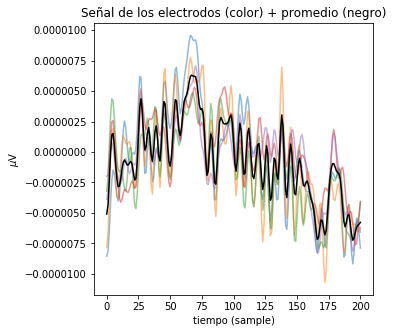

<function __main__.f>

In [20]:
def f(epoch):
    plt.figure(figsize=(5, 5))
    for i in range(len(array_electrodos)):
        plot(recorte[epoch, i, :], alpha=0.5)
    plot(promedio[epoch, :], color='black') 
    xlabel('tiempo (sample)')
    ylabel('$\mu$V')
    title('Señal de los electrodos (color) + promedio (negro)')
interact(f, epoch=(0, 20))

In [21]:
f, Pxx = scs.welch(promedio, fs=FREQ_SAMPLE)

/usr/local/lib/python2.7/dist-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


In [22]:
len(f), len(Pxx)

(101, 894)

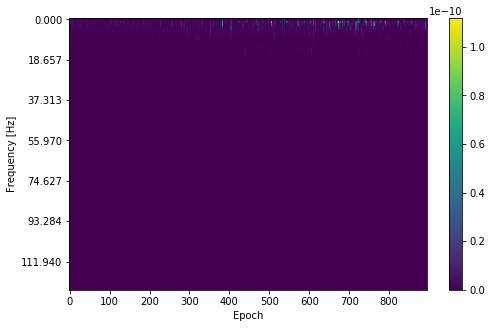

In [23]:
plt.figure(figsize=(8, 5))
imshow(Pxx.T, aspect='auto')
tick_select = range(0, len(f), 15)
tick_labels = ['{:.3f}'.format(x) for x in f[tick_select]]
yticks(tick_select, tick_labels)
xlabel('Epoch')
ylabel('Frequency [Hz]')
colorbar()

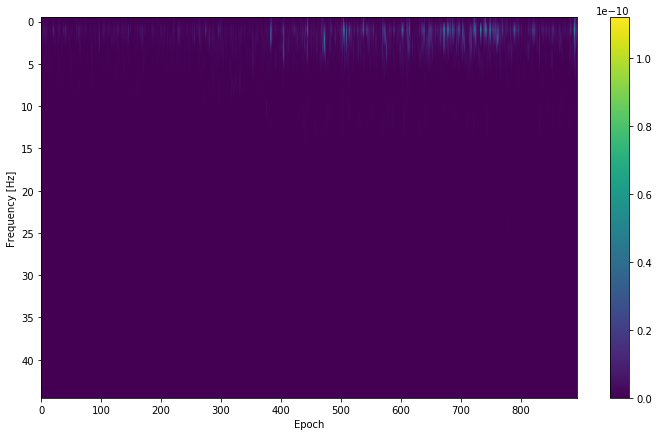

In [24]:
plt.figure(figsize=(12, 7))
imshow(Pxx.T[:45, :], aspect='auto', interpolation='bilinear')
xlabel('Epoch')
ylabel('Frequency [Hz]')
colorbar()

Estudiar el caso de un único sujeto elegido arbritrariamente de ambos grupos nos permite una primera inspección de los datos. Si bien se podría realizar lo mismo para cada uno de los sujetos, resulta interesante realizar "grupal" y promediar las señales obtenidas por grupo. 
Para no tener que abrir todas las matrices, vamos a usar una matriz de _epoch_ x _samples_ como acumulador en la que vamos a sumar los valores de cada matriz. Además vamos a contar para cada _epoch_ cuantos valores se sumaron de forma de saber como promediar.

In [128]:
todas_las_matrices = glob.glob('dataset/*.mat')
matrices_S = glob.glob('dataset/S*.mat') #matrices del grupo S
matrices_P = glob.glob('dataset/P*.mat') #matrices del grupo P

Exploramos los tamaños de las matrices del grupo S para ver si son todas iguales.

In [62]:
#data = []
#names = []
#for i, n, m, t in MatrixProvider(N_MATRICES):
#    data.append([t] + list(sio.loadmat(m)['data'].shape))
#    names.append(os.path.basename(n).replace('.mat', ''))

In [130]:
#no me anda MatrixProvider, uso como estaba antes
data = []
for m in matrices_S:
    data.append([os.path.basename(m)[0]] + list(sio.loadmat(m)['data'].shape))

In [131]:
matrices_S_shapes = pd.DataFrame(data, columns=["Type", "Epochs", "Electrodes", "Samples"])
matrices_S_shapes.T

,0,1,2,3,4,5,6,7,8,9
Type,S,S,S,S,S,S,S,S,S,S
Epochs,800,809,769,657,767,407,789,746,697,628
Electrodes,256,256,256,256,256,256,256,256,256,256
Samples,201,201,201,201,201,201,201,201,201,201


Como se observa en la tabla, todos los sujetos del grupo S completaron como máximo 809 trials. Vemos el promedio general de la cantidad de trials.

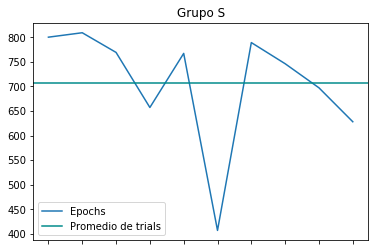

In [132]:
plot(arange(matrices_S_shapes.shape[0]), matrices_S_shapes['Epochs'])
axhline(mean(matrices_S_shapes['Epochs']), xmin=0, xmax=20, color='darkcyan', label='Promedio de trials')
legend()
_ = xticks(arange(matrices_S_shapes.shape[0]), names)
title('Grupo S')

Acumulador para el grupo S

In [134]:
electrodos_selec = [7, 43, 79, 130, 184]
contador_suma = np.zeros(0)
matriz_base = np.zeros((0,201))
#for _, _, nombre_matriz, tipo in MatrixProvider(4):
for nombre_matriz in matrices_S:
    data = sio.loadmat(nombre_matriz)['data']
    recorte = data[:, electrodos_selec, :]
    promedio_S = np.mean(recorte, axis=1)
    
    assert(promedio_S.shape[1] == 201)
    
    # Caso donde la nueva matriz tiene más épocas
    if (promedio_S.shape[0] > contador_suma.shape[0]): 
        tam_ant = contador_suma.shape[0]
        nuevo_contador = np.zeros(promedio_S.shape[0])  # Creo un nuevo arreglo de contadores del nuevo tamaño
        nuevo_contador[:tam_ant] = contador_suma # Actualizo los valores viejos en la región importante
        contador_suma = nuevo_contador 
        
        nueva_matriz = np.zeros((promedio_S.shape[0], 201))  # Creo una nueva matriz del nuevo tamaño
        nueva_matriz[0:matriz_base.shape[0], :] = matriz_base  # Actualizo la región importante
        matriz_base = nueva_matriz
        
    matriz_base[0:promedio_S.shape[0], :] += promedio_S  # Sumo los valores del sujeto en su región
    contador_suma[0:promedio_S.shape[0]] += np.ones(promedio_S.shape[0])  # Sumo uno a cada epoch actualizado

In [135]:
reshape_contador_suma = contador_suma.reshape((contador_suma.shape[0], 1))
promedio_S_gral = matriz_base / reshape_contador_suma

Ya que tenemos el promedio de todos los sujetos del grupo S sobre cada sample, vemos la forma de la onda promediada.

(809, 201)


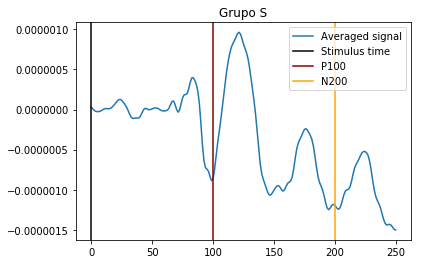

In [136]:
print(promedio_S_gral.shape)
plot(np.arange(201) * (1 / DUR_EPOCH), promedio_S_gral.mean(axis=0), label='Averaged signal')
axvline(0, color='black', label='Stimulus time')
axvline(100, color='darkred', label='P100')
axvline(200, color='orange', label='N200')
_ = legend()
title('Grupo S')

In [137]:
f_S, Pxx_S = scs.welch(promedio_S_gral, fs=FREQ_SAMPLE)

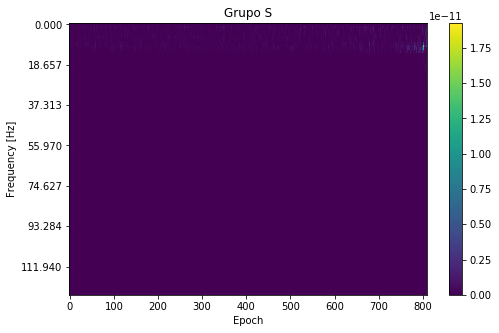

In [138]:
plt.figure(figsize=(8, 5))
imshow(Pxx_S.T, aspect='auto')
tick_select = range(0, len(f_S), 15)
tick_labels = ['{:.3f}'.format(x) for x in f[tick_select]]
yticks(tick_select, tick_labels)
xlabel('Epoch')
ylabel('Frequency [Hz]')
colorbar()
title('Grupo S')

Parecería que las mayores amplitudes se concentran en las frecuencias más bajas. Graficamos los datos nuevamente enfocándonos en un rango de frecuencias cerca de 0.

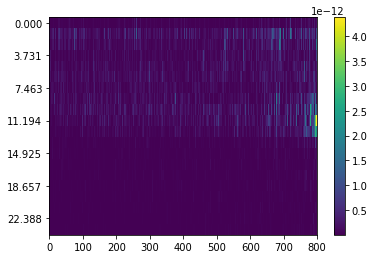

In [104]:
frequency_bin_cutoff = 20
imshow(Pxx_S[:800,:frequency_bin_cutoff].T, aspect='auto')
tick_select = range(0, frequency_bin_cutoff, 3)
tick_labels = ['{:.3f}'.format(x) for x in f[tick_select]]
yticks(tick_select, tick_labels)
colorbar()
title('Grupo S')

Procedemos de igual modo para el grupo P

In [139]:
data = []
for m in matrices_P:
    data.append([os.path.basename(m)[0]] + list(sio.loadmat(m)['data'].shape))

In [140]:
matrices_P_shapes = pd.DataFrame(data, columns=["Type", "Epochs", "Electrodes", "Samples"])
matrices_P_shapes.T

,0,1,2,3,4,5,6,7,8,9
Type,P,P,P,P,P,P,P,P,P,P
Epochs,901,944,1596,539,857,947,687,700,931,894
Electrodes,256,256,256,256,256,256,256,256,256,256
Samples,201,201,201,201,201,201,201,201,201,201


A diferencia del grupo anterior, en este caso más de la mitad de los sujetos P completaron más de 800 trials. Esto se verá además en los gráficos siguientes.

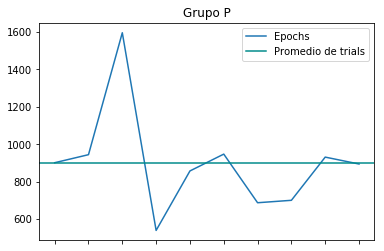

In [141]:
plot(arange(matrices_P_shapes.shape[0]), matrices_P_shapes['Epochs'])
axhline(mean(matrices_P_shapes['Epochs']), xmin=0, xmax=20, color='darkcyan', label='Promedio de trials')
legend()
_ = xticks(arange(matrices_P_shapes.shape[0]), names)
title('Grupo P')

In [142]:
contador_suma = np.zeros(0)
matriz_base = np.zeros((0,201))
#for _, _, nombre_matriz, tipo in MatrixProvider(4):
for nombre_matriz in matrices_P:
    data = sio.loadmat(nombre_matriz)['data']
    recorte = data[:, electrodos_selec, :]
    promedio_P = np.mean(recorte, axis=1)
    
    assert(promedio_P.shape[1] == 201)
    
    # Caso donde la nueva matriz tiene más épocas
    if (promedio_P.shape[0] > contador_suma.shape[0]): 
        tam_ant = contador_suma.shape[0]
        nuevo_contador = np.zeros(promedio_P.shape[0])  # Creo un nuevo arreglo de contadores del nuevo tamaño
        nuevo_contador[:tam_ant] = contador_suma # Actualizo los valores viejos en la región importante
        contador_suma = nuevo_contador 
        
        nueva_matriz = np.zeros((promedio_P.shape[0], 201))  # Creo una nueva matriz del nuevo tamaño
        nueva_matriz[0:matriz_base.shape[0], :] = matriz_base  # Actualizo la región importante
        matriz_base = nueva_matriz
        matriz_base[0:promedio_P.shape[0], :] += promedio_P  # Sumo los valores del sujeto en su región
    contador_suma[0:promedio_P.shape[0]] += np.ones(promedio_P.shape[0])  # Sumo uno a cada epoch actualizado

In [143]:
reshape_contador_suma = contador_suma.reshape((contador_suma.shape[0], 1))
promedio_P_gral = matriz_base / reshape_contador_suma

(1596, 201)


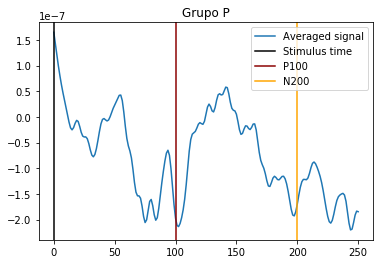

In [144]:
print(promedio_P_gral.shape)
plot(np.arange(201) * (1 / DUR_EPOCH), promedio_P_gral.mean(axis=0), label='Averaged signal')
axvline(0, color='black', label='Stimulus time')
axvline(100, color='darkred', label='P100')
axvline(200, color='orange', label='N200')
_ = legend()
title('Grupo P')

In [145]:
f_P, Pxx_P = scs.welch(promedio_P_gral, fs=FREQ_SAMPLE)

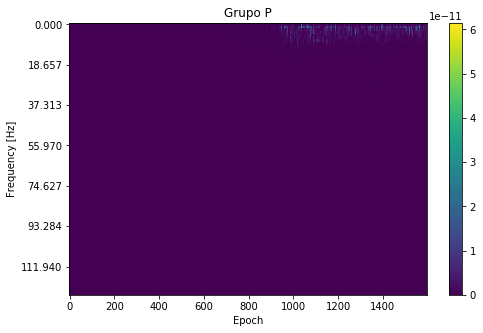

In [146]:
plt.figure(figsize=(8, 5))
imshow(Pxx_P.T, aspect='auto')
tick_select = range(0, len(f_P), 15)
tick_labels = ['{:.3f}'.format(x) for x in f[tick_select]]
yticks(tick_select, tick_labels)
xlabel('Epoch')
ylabel('Frequency [Hz]')
title('Grupo P')
colorbar()

Nuevamente habría que observar las frecuencias más bajas. Por otro lado, y como ya fue mencionado anteriormente, la cantidad de trials de este grupo es superior a la del grupo S. Teniéndolo en cuenta, se ajusta el eje para una mejor apreciación de los resultados.

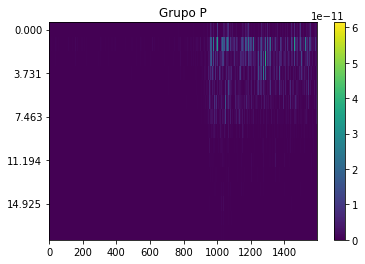

In [150]:
frequency_bin_cutoff = 15
imshow(Pxx_P[:1600,:frequency_bin_cutoff].T, aspect='auto')
tick_select = range(0, frequency_bin_cutoff, 3)
tick_labels = ['{:.3f}'.format(x) for x in f[tick_select]]
yticks(tick_select, tick_labels)
colorbar()
title('Grupo P')

### 2.a.2: Calcular la potencia media (entre epochs) para cada frecuencia y graficar la potencia en funcion de la frecuencia para cada canal

<p style="text-align: justify;">
Calculamos el espectro para un sujeto.
</p> 

In [151]:
freq, Pxx_trials = scs.welch(p01_mat[:,:,:], fs=FREQ_SAMPLE)
Pxx_channels = np.mean(Pxx_trials, axis=0)

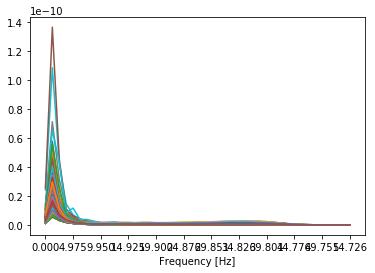

In [152]:
plot(Pxx_channels.T[:45,:])
freq_select = range(0, 45, 4)
freq_labels = ['{:.3f}'.format(freq[i]) for i in freq_select]
xticks(freq_select, freq_labels)
_ = xlabel('Frequency [Hz]')

<p style="text-align: justify;">
En este caso, la frecuencia de Nyquist es 125 Hz, aunque el filtro aplicado en el pre-procesamiento pone el límite en 45 Hz.
</p> 

### Bandas de frecuencias

<p style="text-align: justify;">
Un EEG es tipicamente descripto en terminos de oscilaciones. Estas oscilaciones son agrupadas en bandas de frecuencia:
<ul>
<li> Delta $<$ 4 Hz </li>
<li> 4 Hz $<=$ Theta $<$ 8 Hz </li>
<li> 8 Hz $<=$ Alpha $<$ 13 Hz </li>
<li> 13 Hz $<=$ Beta $<$ 30 Hz </li>
<li> 30 Hz $<=$ Gamma $<$ NyquistHighpass en 0.5 Hz (butterworth de orden 6) </li>
</ul>  
El cálculo del poder espectral en cada banda se realiza sumando los valores obtenidos de la FFT que corresponden a las frecuencias incluídas en la misma. Adicionalmente, suelen computarse los valores normalizados, que indican la relación entre el poder espectral de cada banda sobre el poder espectral total.
</p> 

<p style="text-align: justify;">
Calculamos el poder espectral de cada banda de frecuencias para cada canal para un sujeto. </p> 

In [153]:
Pxx_channels_delta = np.sum(Pxx_channels [:, freq < 4], axis=1)
#Pxx_channels_delta
#idx = (freq > 4)*(freq < 8)
#np.where(idx)
Pxx_channels_theta = np.sum(Pxx_channels [:, (freq >= 4)*(freq < 8)], axis=1)
Pxx_channels_alpha = np.sum(Pxx_channels [:, (freq >= 8)*(freq < 13)], axis=1)
Pxx_channels_beta = np.sum(Pxx_channels [:, (freq >= 13)*(freq < 30)], axis=1)
Pxx_channels_gamma = np.sum(Pxx_channels [:, freq >= 30], axis=1)

<p style="text-align: justify;">
Promediamos entre canales.
</p> 

In [154]:
P_delta = np.mean(Pxx_channels_delta)
P_theta = np.mean(Pxx_channels_theta)
P_alpha = np.mean(Pxx_channels_alpha)
P_beta = np.mean(Pxx_channels_beta)
P_gamma = np.mean(Pxx_channels_gamma)

<p style="text-align: justify;">
Ahora lo calculamos para todos los sujetos.
</p> 

In [156]:
dataDir = "dataset/"
filelist = [x for x in os.listdir(dataDir) if x.endswith('.mat')]

Banda de frecuencia alpha

In [160]:
fs=FREQ_SAMPLE
count = 0
P_alpha_subjects = np.zeros(len(filelist))
#for idx, name, path, type in MatrixProvider(N_MATRICES):
for f in range(len(filelist)):
    file = filelist[f]
    data = sio.loadmat( dataDir + file )
    #data = sio.loadmat( path )
    data_array = data['data']
    freq_subjects, Pxx_trials_subjects = scs.welch(data_array[:,:,:], fs=fs)
    Pxx_channels_subjects = np.mean(Pxx_trials_subjects, axis=0)
    Pxx_channels_alpha_subjects = np.sum(Pxx_channels_subjects [:, (freq >= 8)*(freq < 13)], axis=1)
    # promedio
    P_alpha_subjects[f] = np.mean(Pxx_channels_alpha_subjects)
    # para la progress bar
    count += 1
    
with open('P_alpha_subjects.pkl', 'w') as f:
    pickle.dump(P_alpha_subjects, f)

<p style="text-align: justify;">
Ploteamos los valores de potencia espectral de la banda alpha obtenidos para todos los sujetos.
</p> 

In [161]:
with open('P_alpha_subjects.pkl', 'r') as f:
    P_alpha_subjects = pickle.load(f)

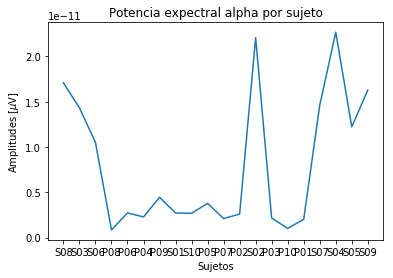

In [165]:
plot(P_alpha_subjects)
subject_names = [os.path.basename(n).replace('.mat','') for n in filelist]
#subject_names = [name.replace('.mat', '') for name, _, _ in MatrixProvider(N_MATRICES)]
xlabel('Sujetos')
xticks(arange(20), subject_names)
ylabel('Amplitudes [$\mu$V]')
title('Potencia expectral alpha por sujeto')
plt.show()

<p style="text-align: justify;">
Ploteamos las distribuciones de potencia espectral de la banda alpha separando los sujetos en grupos de controles y pacientes.
</p> 

### Gráficos categóricos de seaborn (8 tipos)

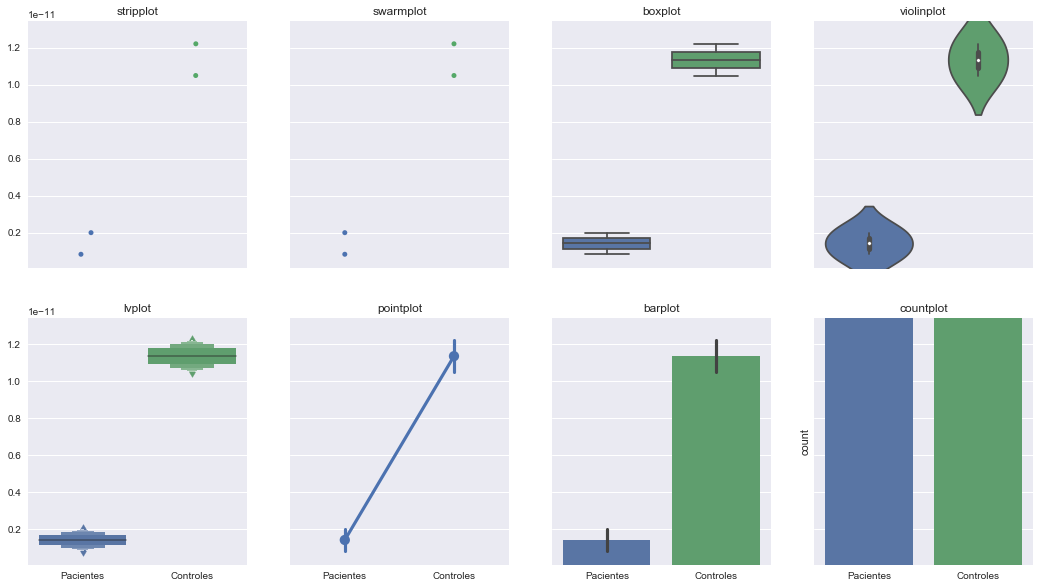

In [39]:
etiquetas = ['Pacientes' if n.startswith('P') else 'Controles' for n in subject_names] 

#etiquetas = []
#for n in subject_names:
#    if n.startswith('P'):
#        etiquetas.append('Pacientes')
#    else:
#        etiquetas.append('Controles')
        
fig, axs = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True, figsize=(18, 10))
it_axs = iter(array(axs).flatten())

sca(it_axs.next())
ax = sns.stripplot(x=etiquetas, y=P_alpha_subjects, jitter=1)
plt.ylim(min(P_alpha_subjects) * 0.1, max(P_alpha_subjects) * 1.1)
ax.set_title('stripplot')

sca(it_axs.next())
ax = sns.swarmplot(x=etiquetas, y=P_alpha_subjects)
ax.set_title('swarmplot')

sca(it_axs.next())
ax = sns.boxplot(x=etiquetas, y=P_alpha_subjects)
ax.set_title('boxplot')

sca(it_axs.next())
ax = sns.violinplot(x=etiquetas, y=P_alpha_subjects)
ax.set_title('violinplot')

sca(it_axs.next())
ax = sns.lvplot(x=etiquetas, y=P_alpha_subjects)
ax.set_title('lvplot')

sca(it_axs.next())
ax = sns.pointplot(x=etiquetas, y=P_alpha_subjects)
ax.set_title('pointplot')

sca(it_axs.next())
ax = sns.barplot(x=etiquetas, y=P_alpha_subjects)
ax.set_title('barplot')

sca(it_axs.next())
ax = sns.countplot(x=etiquetas, data=pd.DataFrame(P_alpha_subjects))
ax.set_title('countplot')

<p style="text-align: justify;">
Para cada banda de frecuencia, graficar según lo elegido previamente y realizar un test estadístico apropiado. Repetir los análisis para los valores normalizados.
</p> 

Se confeccionan gráficos del tipo Violinplots para el resto de las bandas espectrales. Se utiliza este tipo de gráfico ya que se puede visualizar la distribución de los datos y su densidad de probabilidad. El rectángulo negro del centro representa el rango intercuartil, la línea negra el intervalo de confianza del 95% y el punto blanco central la mediana de los datos.

In [167]:
fs=FREQ_SAMPLE
count = 0
P_delta_subjects = np.zeros(len(filelist))
P_theta_subjects = np.zeros(len(filelist))
P_beta_subjects = np.zeros(len(filelist))
P_gamma_subjects = np.zeros(len(filelist))
#for idx, name, path, type in MatrixProvider(N_MATRICES):
for f in range(len(filelist)):
    file = filelist[f]
    data = sio.loadmat( dataDir + file )
    #data = sio.loadmat( path )
    data_array = data['data']
    freq_subjects, Pxx_trials_subjects = scs.welch(data_array[:,:,:], fs=fs)
    Pxx_channels_subjects = np.mean(Pxx_trials_subjects, axis=0)
    Pxx_channels_delta_subjects = np.sum(Pxx_channels_subjects [:, freq < 4], axis=1)
    Pxx_channels_theta_subjects = np.sum(Pxx_channels_subjects [:, (freq >= 4)*(freq < 8)], axis=1)
    Pxx_channels_beta_subjects = np.sum(Pxx_channels_subjects [:, (freq >= 13)*(freq < 30)], axis=1)
    Pxx_channels_gamma_subjects = np.sum(Pxx_channels_subjects [:, freq >= 30], axis=1)
    # promedio
    P_delta_subjects[f] = np.mean(Pxx_channels_delta_subjects)
    P_theta_subjects[f] = np.mean(Pxx_channels_theta_subjects)
    P_beta_subjects[f] = np.mean(Pxx_channels_beta_subjects)
    P_gamma_subjects[f] = np.mean(Pxx_channels_gamma_subjects)
    # para la progress bar
    count += 1

with open('P_delta_subjects.pkl', 'w') as f:
    pickle.dump(P_delta_subjects, f)
with open('P_theta_subjects.pkl', 'w') as f:
    pickle.dump(P_theta_subjects, f)
with open('P_beta_subjects.pkl', 'w') as f:
    pickle.dump(P_beta_subjects, f)
with open('P_gamma_subjects.pkl', 'w') as f:
    pickle.dump(P_gamma_subjects, f)

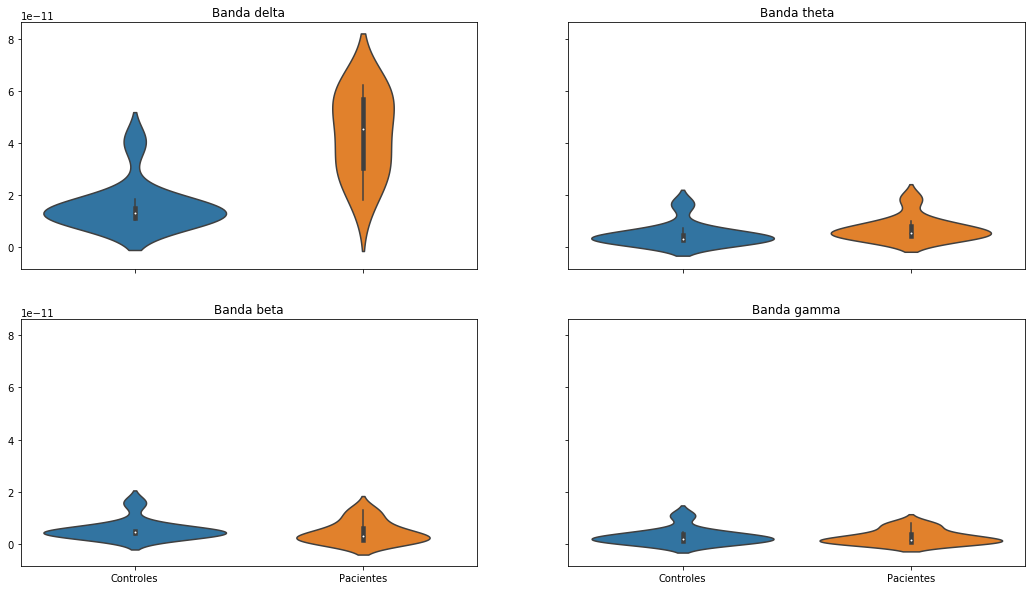

In [168]:
etiquetas = ['Pacientes' if n.startswith('P') else 'Controles' for n in subject_names] 

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(18, 10))
it_axs = iter(array(axs).flatten())


sca(it_axs.next())
ax = sns.violinplot(x=etiquetas, y=P_delta_subjects)
ax.set_title('Banda delta')

sca(it_axs.next())
ax = sns.violinplot(x=etiquetas, y=P_theta_subjects)
ax.set_title('Banda theta')

sca(it_axs.next())
ax = sns.violinplot(x=etiquetas, y=P_beta_subjects)
ax.set_title('Banda beta')

sca(it_axs.next())
ax = sns.violinplot(x=etiquetas, y=P_gamma_subjects)
ax.set_title('Banda gamma')


Se procede a realizar test estadísticos que permitan una mejor comprensión de los datos. En primer lugar se querrá ver si las muestras de ambos grupos provienen de una distribución normal (test KS) y cómo es su varianza (test Levene).

Para cada array de cada banda espectral separo los valores según correspondan al grupo S o al grupo P

In [198]:
#aca separo segun las etiquetas 'Controles' y 'Pacientes'
etiquetas_de = lambda tipo: filter(lambda subj_i : etiquetas[subj_i] == tipo, range(20))
etiquetas_de_controles = etiquetas_de('Controles')
etiquetas_de_pacientes = etiquetas_de('Pacientes')

In [205]:
#aca obtengo las bandas espectrales para los controles
bandas_espectrales_c = lambda banda: np.array(map(lambda indice_c : banda[indice_c], etiquetas_de_controles))
banda_alpha_c = bandas_espectrales_c(P_alpha_subjects)
banda_beta_c = bandas_espectrales_c(P_beta_subjects)
banda_theta_c = bandas_espectrales_c(P_theta_subjects)
banda_delta_c = bandas_espectrales_c(P_delta_subjects)
banda_gamma_c = bandas_espectrales_c(P_gamma_subjects)

In [206]:
#aca obtengo las bandas espectrales para los pacientes
bandas_espectrales_p = lambda banda: np.array(map(lambda indice_p : banda[indice_p], etiquetas_de_pacientes))
banda_alpha_p = bandas_espectrales_p(P_alpha_subjects)
banda_beta_p = bandas_espectrales_p(P_beta_subjects)
banda_theta_p = bandas_espectrales_p(P_theta_subjects)
banda_delta_p = bandas_espectrales_p(P_delta_subjects)
banda_gamma_p = bandas_espectrales_p(P_gamma_subjects)

In [224]:
#Grupo S
t_delta_c, p_delta_c = sp.stats.kstest((banda_delta_c - banda_delta_c.mean())/banda_delta_c.std(), 'norm')
t_theta_c, p_theta_c = sp.stats.kstest((banda_theta_c - banda_theta_c.mean())/banda_theta_c.std(), 'norm')
t_alpha_c, p_alpha_c = sp.stats.kstest((banda_alpha_c - banda_alpha_c.mean())/banda_alpha_c.std(), 'norm')
t_beta_c, p_beta_c = sp.stats.kstest((banda_beta_c - banda_beta_c.mean())/banda_beta_c.std(), 'norm')
t_gamma_c, p_gamma_c = sp.stats.kstest((banda_gamma_c - banda_gamma_c.mean())/banda_gamma_c.std(), 'norm')

print('Grupo S')
pd.DataFrame({'delta':{'t': t_delta_c, 'p': p_delta_c}, 'theta': {'t': t_theta_c, 'p': p_theta_c}, 'alpha':{'t': t_alpha_c, 'p': p_alpha_c}, 'beta':{'t': t_beta_c, 'p': p_beta_c}, 'gamma':{'t': t_gamma_c, 'p': p_gamma_c}})

Grupo S


,alpha,beta,delta,gamma,theta
p,0.975901,0.070240,0.158359,0.646628,0.199582
t,0.151418,0.389953,0.338851,0.222757,0.322751


Observando los valores de p obtenidos se tiene que la banda espectral alpha proviene de una distribucion normal. No puede decirse lo mismo de las restantes.

In [223]:
t_delta_p, p_delta_p = sp.stats.kstest((banda_delta_p - banda_delta_p.mean())/banda_delta_p.std(), 'norm')
t_theta_p, p_theta_p = sp.stats.kstest((banda_theta_p - banda_theta_p.mean())/banda_theta_p.std(), 'norm')
t_alpha_p, p_alpha_p = sp.stats.kstest((banda_alpha_p - banda_alpha_p.mean())/banda_alpha_p.std(), 'norm')
t_beta_p, p_beta_p = sp.stats.kstest((banda_beta_p - banda_beta_p.mean())/banda_beta_p.std(), 'norm')
t_gamma_p, p_gamma_p = sp.stats.kstest((banda_gamma_p - banda_gamma_p.mean())/banda_gamma_p.std(), 'norm')

print('Grupo P')
pd.DataFrame({'delta':{'t': t_delta_p, 'p': p_delta_p}, 'theta': {'t': t_theta_p, 'p': p_theta_p}, 'alpha':{'t': t_alpha_p, 'p': p_alpha_p}, 'beta':{'t': t_beta_p, 'p': p_beta_p}, 'gamma':{'t': t_gamma_p, 'p': p_gamma_p}})

Grupo P


,alpha,beta,delta,gamma,theta
p,0.919232,0.425837,0.958085,0.404284,0.551971
t,0.175040,0.262618,0.160875,0.267152,0.238697


En este caso, observando los valores de p obtenidos se tiene que las bandas espectrales alpha y delta provienen de una distribucion normal. No puede decirse lo mismo de las restantes.

Se estudian las varianzas de las muestras por banda espectral con el test de Levene

In [226]:
t_alpha, p_alpha = sp.stats.levene(banda_alpha_c, banda_alpha_p)
t_beta, p_beta = sp.stats.levene(banda_beta_c, banda_beta_p)
t_delta, p_delta = sp.stats.levene(banda_delta_c, banda_delta_p)
t_theta, p_theta = sp.stats.levene(banda_theta_c, banda_theta_p)
t_gamma, p_gamma = sp.stats.levene(banda_gamma_c, banda_gamma_p)

pd.DataFrame({'delta':{'t': t_delta, 'p': p_delta}, 'theta': {'t': t_theta, 'p': p_theta}, 'alpha':{'t': t_alpha, 'p': p_alpha}, 'beta':{'t': t_beta, 'p': p_beta}, 'gamma':{'t': t_gamma, 'p': p_gamma}})

,alpha,beta,delta,gamma,theta
p,0.008333,0.414416,0.022919,0.885853,0.771732
t,8.777902,0.697980,6.185160,0.021200,0.086740


Según los valores de p obtenidos a partir del test de Levene, se puede decir que dentro de la banda espectral gamma, los grupos tienen varianzas iguales, para los demas casos se asumirán distintas.

Teniendo en cuenta los test ya hechos se prosigue en hacer un t-test para muestras independientes para cada banda espectral.

In [229]:
t_alpha, p_alpha = sp.stats.ttest_ind(banda_alpha_c, banda_alpha_p, equal_var=False)
t_beta, p_beta = sp.stats.ttest_ind(banda_beta_c, banda_beta_p, equal_var=False)
t_delta, p_delta = sp.stats.ttest_ind(banda_delta_c, banda_delta_p, equal_var=False)
t_theta, p_theta = sp.stats.ttest_ind(banda_theta_c, banda_theta_p, equal_var=False)
t_gamma, p_gamma = sp.stats.ttest_ind(banda_gamma_c, banda_gamma_p)

pd.DataFrame({'delta':{'t': t_delta, 'p': p_delta}, 'theta': {'t': t_theta, 'p': p_theta}, 'alpha':{'t': t_alpha, 'p': p_alpha}, 'beta':{'t': t_beta, 'p': p_beta}, 'gamma':{'t': t_gamma, 'p': p_gamma}})

,alpha,beta,delta,gamma,theta
p,0.000584,0.580388,0.000245,0.817945,0.286993
t,5.059723,0.563076,-4.836397,0.233583,-1.097296


En los casos de las abndas espectrales alpha, delta y theta los valores de p obtenidos son bajos (< 0.3) por lo que descartaremos la hipótesis nula de que las muestras en esas bandas tienen igual media. No sucede lo mismo para el caso de la banda gamma con p = 0.817 y beta con p = 0.580.

<a name="informacion"></a>
## 3. Análisis de información

<p style="text-align: justify;">
Los métodos basados en teoría de la información como entropía, entropia mutua, entropía condicional e información mutua forman un conjunto de técnicas estadísticas/matemáticas de gran utilidad en ciencia, ingeniería y comunicaciones. Las métricas basadas en la teoría de la información crean un marco para la cuantificación de información y conectividad entre señales. En el caso de EEG, puede ser para evaluar la cantidad de información en cada electrodo, la información mutua o conectividad entre pares de electrodos, etc.
</p> 

<a name="informacion-intra-nodo"></a>
### 3.1. Análisis de información intra-electrodo

<p style="text-align: justify;">
Calculamos distintas medidas de información intra-electrodos para cada serie temporal. 
</p> 

<p style="text-align: justify;">
La entropía es una medida de la cantidad de información que posee una serie de símbolos. La formula esta data por: 
</p> 
\begin{equation*}
H (X) = - \sum_{i=1}^n p(x_{i})\ log[p(x_{i})]
\end{equation*}
donde n es el número de símbolos y p(x) es la probabilidad de observar x.

<p style="text-align: justify;">
Utilizamos la regla de *Scott* para definir el valor óptimo del número de bins N a partir de las propiedades de las series.
</p> 

In [10]:
def scott(vs):
    r = max(vs) - min(vs)
    s = np.std(vs)
    n_mult = pow(len(vs), -1/3.)
    scott_N = r / (3.5 * s * n_mult)
    return int(np.ceil(scott_N))
N = scott(p01_mat[0,0,:])
N

7

<p style="text-align: justify;">
Ahora calculamos el histograma definiendo como parámetro que use la regla de *Scott* para definir el valor óptimo del número de bins N a partir de las propiedades de las series.
</p> 

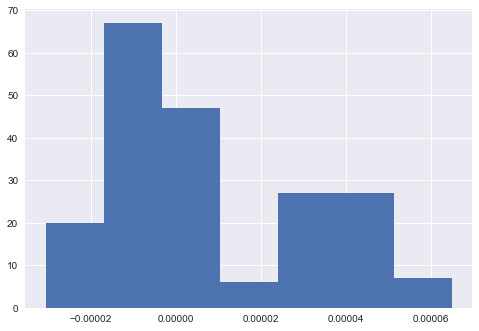

In [11]:
hist, bin_edges = np.histogram(p01_mat[0, 0, :], bins='scott')
_ = plt.hist(p01_mat[0, 0, :], bin_edges)

<p style="text-align: justify;">
Como se puede observar, el histograma usa la cantidad de bins calculada mediante la regla de *Scott*.
</p> 

<p style="text-align: justify;">
Calculamos la entropía para esa serie en particular.
</p> 

In [12]:
sp.stats.entropy(hist/sum(hist))

1.6966725355534216

<p style="text-align: justify;">
Calculamos la matriz de entropías de todas las series para un sujeto.
</p> 

In [26]:
def subject_entropy(subject_matrix):
    H = np.zeros((subject_matrix.shape[0], subject_matrix.shape[1]))
    for i in range(subject_matrix.shape[0]):
        for j in range(subject_matrix.shape[1]):
            hist, bin_edges = np.histogram(subject_matrix[i, j, :], bins='scott')
            H [i, j] = sp.stats.entropy(hist/sum(hist))
    return H

In [14]:
H = subject_entropy(p01_mat)

<p style="text-align: justify;">
Corroboramos que el elemento de matriz correspondiente al cálculo anterior de el mismo valor.
</p> 

In [15]:
H[0,0]

1.6966725355534216

<p style="text-align: justify;">
Calculamos la entropía media entre canales y trials para ese sujeto.
</p> 

In [16]:
Hmean = np.mean(H)
Hmean

1.8763243979678581

<p style="text-align: justify;">
Entonces ya tenemos cómo calcular la entropía media para cada sujeto. Corremos un loop entre todos los sujetos guardando los resultados de entropía media por sujeto.
</p> 

In [30]:
dataDir = "dataset/"
filelist = os.listdir( dataDir )

# progress bar
pbar = FloatProgress(min=0, max=len(filelist)) # instantiate the bar
display(pbar) # display the bar

count = 0
Hmean = np.zeros(len(filelist))
for f in range(len(filelist)):
    file = filelist[f]
    data = sio.loadmat( dataDir+file )
    data_array = data['data']
    
    H = subject_entropy(data_array)
    Hmean[f] = np.mean(H)
    
    pbar.value += 1 # signal to increment the progress bar
    time.sleep(.1)
    count += 1

<p style="text-align: justify;">
Ploteamos las distribuciones de entropías media separando los sujetos en grupos de controles y pacientes.
</p> 

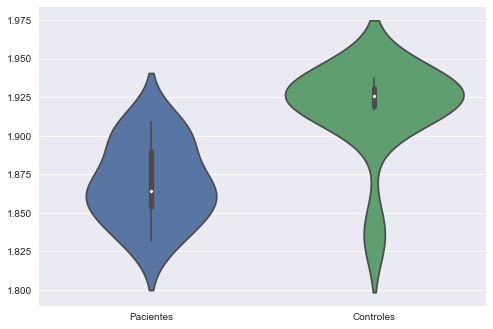

In [34]:
subject_names = [os.path.basename(n).replace('.mat','') for n in filelist]
etiquetas = ['Pacientes' if n.startswith('P') else 'Controles' for n in subject_names]
ax = sns.violinplot(x=etiquetas, y=Hmean)

<p style="text-align: justify;">
Aplicamos el test no paramétrico de Kolmogorov-Smirnov para comparar ambas distribuciones de entropía media.
</p> 

In [68]:
labels = [[0] if n.startswith('P') else [1] for n in subject_names]
labels_array = pd.DataFrame(labels)
H_pacientes = Hmean[np.where(labels_array == 0)[0]]
H_controles = Hmean[np.where(labels_array == 1)[0]]

sp.stats.ks_2samp(H_pacientes, H_controles)

Ks_2sampResult(statistic=0.90000000000000002, pvalue=0.00017011925273829754)

<p style="text-align: justify;">
Se observa que el p-valor es muy bajo, por lo que se rechaza la hipótesis nula de que ambos conjuntos de datos provienen de la misma distribución. De esta manera, los valores de entropía media de los sujetos difieren entre los grupos.
</p> 

<a name="informacion-inter-nodo"></a>
### 3.2. Análisis de información inter-electrodo

<p style="text-align: justify;">
La información mutua, como su nombre lo define, es la cantidad de información que dos variables comparten. Una forma de expresar la información mutua es en función de la entropía y la entropía conjunta:
</p> 
\begin{equation*}
I(X; Y) = H (X) - H (X|Y) = H (X) + H (Y) - H (X,Y) = \sum_{x} \sum_{y} p(x, y) log\frac{p(x, y)}{p(x) p(y)}
\end{equation*}

<p style="text-align: justify;">
Definimos la función que calcula la informacion mutua usando los histogramas bivariados entre las señales.
</p> 

In [ ]:
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

<p style="text-align: justify;">
Calculamos
</p> 

<a name="informacion-simbolica"></a>
### 3.3. Transformación simbólica

<p style="text-align: justify;">
Todas las medidas descriptas previamente trabajan sobre seríes simbólicas con alfabetos finitos, como por ejemplo, texto ASCII. Sin embargo, los datos de EEG estan guardados como elementos de punto flotante de doble precision (64 bits). Si calculamos la entropía de un canal de EEG de 300 muestras, probablemente obtengamos que la probabilidad de obtener cada simbolo posible es 0 o 1/300. El alfabeto sigue siendo finito con $2^{64}$ elementos, pero la cantidad de simbolos es muy grande.

Una solución a este problema consiste en transformar la serie temporal de punto flotante a una serie simbólica con un alfabeto finito de cardinalidad acotada.
</p> 

<p style="text-align: justify;">
Para la transformación simbólica de las series, seguimos el procedimiento descrito en *King, Sitt et al 2013*. De esta manera, partimos la serie temporal en sub-vectores de k datos (k=3) y nos fijamos qué formas distintas pueden tener esos sub-vectores de acuerdo al orden de sus valores de intensidad. Para k=3, las formas posibles son 3!=6. En la siguiente figura se pueden observar las formas posibles y su símbolo asignado.
</p> 

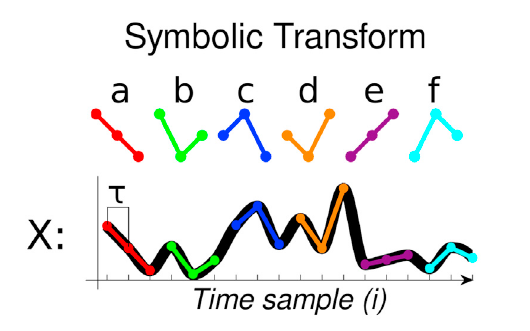

In [16]:
from IPython.display import Image
Image("symb.png")

<p style="text-align: justify;">
De esta manera se observa que si los índices del orden descendente de los valores de intensidad del sub-vector son [0 1 2] entonces se le asigna el símbolo 'a', si son [0 2 1] se le asigna 'b', etc. También se puede observar que los k elementos del sub-vector pueden ser asignado a tiempos consecutivos (Tau = 1 sample) o que se pueden seleccionar de manera salteada. Por ejemplo, se pueden elegir con Tau = 2, 4, 8 samples.
</p> 

    Para Tau's distintos a 1 sample, los subvectores se arman de manera concatenada y sin overlapping? Estaría tirando un montón de datos. Y no le estaría dando más importancia al 1er valor de la serie (por ejemplo) que a otros? Puedo confíar más en ese valor que en otros?

### Entropía de los vectores simbólicos

<p style="text-align: justify;">
Aplicamos la transformación simbólica de una serie de prueba.
</p> 

In [6]:
#np.reshape(p01_mat[0, 0, :],(3, -1)).shape
index = pd.DataFrame(np.argsort(np.reshape(p01_mat[0, 0, :],(3, -1)).T))
index_symbs = pd.DataFrame([[0, 1, 2],[0, 2, 1],[1, 0, 2],[1, 2, 0],[2, 1, 0],[2, 0, 1]], index=['a','b','c','d','e','f'])
symbs = np.zeros(int(len(p01_mat[0, 0, :])/3))
for s in range(index_symbs.shape[0]):
    index_symb = pd.Series(index_symbs.iloc[s])
    #np.where((index == index_symb).all(axis=1))
    symbs[np.where((index[0] == index_symb[0]) & (index[1] == index_symb[1]) & (index[2] == index_symb[2]))[0]] = s
symbs

array([ 1.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  5.,  5.,  5.,  1.,  3.,
        5.,  5.,  1.,  0.,  0.,  1.,  5.,  1.,  1.,  5.,  5.,  5.,  5.,
        5.,  1.,  2.,  2.,  0.,  1.,  5.,  5.,  5.,  5.,  1.,  1.,  1.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  1.,  1.,  1.,  4.,  3.,
        2.,  2.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,
        2.,  3.])

<p style="text-align: justify;">
Hacemos la transformación simbólica de las series y calculamos la entropía media para cada sujeto.
</p> 

** No correr. Tarda una eternidad**

In [12]:
symbs = [str(array(x)) for x in [0, 1, 2],[0, 2, 1],[1, 0, 2],[1, 2, 0],[2, 1, 0],[2, 0, 1]]
valores = list('abcdef')
symbs_dict = dict(zip(symbs, valores))

In [14]:
dataDir = "dataset/"
filelist = os.listdir( dataDir )

# progress bar
pbar = FloatProgress(min=0, max=len(filelist)) # instantiate the bar
display(pbar) # display the bar

count = 0
Hmean_symb = np.zeros(len(filelist))
for f in range(len(filelist)):
    file = filelist[f]
    data = sio.loadmat( dataDir+file )
    data_array = data['data']
    H_symb = np.zeros((data_array.shape[0], data_array.shape[1]))
    for i in range(data_array.shape[0])[:1]:
        for j in range(data_array.shape[1])[:1]:
            r = np.reshape(data_array[i, j, :], (3, -1)).T
            index = np.argsort(r)
            index_str = [str(index[i]) for i in range(index.shape[0])]
            symbs = [symbs_dict[i] for i in index_str]
            
            hist, bin_edges = np.histogram(symbs)
            H_symb [i, j] = sp.stats.entropy(hist/len(symbs), qk=None)
    Hmean_symb[f] = np.mean(H_symb)
    pbar.value += 1 # signal to increment the progress bar
    time.sleep(.1)
    count += 1
    

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


TypeError: cannot perform reduce with flexible type

In [ ]:
plot(Hmean_symb)
#filelist
#etiquetas = np.repeat(['Pacientes','Controles'], 10)

In [ ]:
ax = sns.violinplot(x=etiquetas, y=Hmean_symb)

### Información mutua de los vectores simbólicos

<p style="text-align: justify;">
Aplicamos la transformación simbólica de una serie de prueba.
</p> 

In [6]:
#np.reshape(p01_mat[0, 0, :],(3, -1)).shape
index = pd.DataFrame(np.argsort(np.reshape(p01_mat[0, 0, :],(3, -1)).T))
index_symbs = pd.DataFrame([[0, 1, 2],[0, 2, 1],[1, 0, 2],[1, 2, 0],[2, 1, 0],[2, 0, 1]], index=['a','b','c','d','e','f'])
symbs = np.zeros(int(len(p01_mat[0, 0, :])/3))
for s in range(index_symbs.shape[0]):
    index_symb = pd.Series(index_symbs.iloc[s])
    #np.where((index == index_symb).all(axis=1))
    symbs[np.where((index[0] == index_symb[0]) & (index[1] == index_symb[1]) & (index[2] == index_symb[2]))[0]] = s
symbs

array([ 1.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  5.,  5.,  5.,  1.,  3.,
        5.,  5.,  1.,  0.,  0.,  1.,  5.,  1.,  1.,  5.,  5.,  5.,  5.,
        5.,  1.,  2.,  2.,  0.,  1.,  5.,  5.,  5.,  5.,  1.,  1.,  1.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  1.,  1.,  1.,  4.,  3.,
        2.,  2.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,
        2.,  3.])

<p style="text-align: justify;">
Calculamos la información mutua del vector simbólico calculado previamente consigo mismo, como prueba de la herramienta.
</p> 

In [14]:
MI = normalized_mutual_info_score(symbs, symbs)
MI

1.0

In [15]:
MI = (1/6) * mutual_info_score(symbs, symbs) # SMI segun paper King, Sitt et al 2013
MI

0.022370494017060746

<p style="text-align: justify;">
Para el cálculo de la wSMI (información mutua simbólica pesada) tendríamos que aplicar una máscara que tenga 1s sólo en las diagonales y contradiagonales, de acuerdo a lo hecho en *King, Sitt et al 2013*.
</p> 